# LSTM

## Read data

In [203]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from typing import List
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch
from torchtune.datasets import ConcatDataset

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

In [169]:
print(df_price.index.min())
print(df_price.index.max())
df_price.head()

0
35063


,date,price
0,2016-12-31 23:00:00+00:00,58.82
1,2017-01-01 00:00:00+00:00,58.23
2,2017-01-01 01:00:00+00:00,51.95
3,2017-01-01 02:00:00+00:00,47.27
4,2017-01-01 03:00:00+00:00,45.49


In [170]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [171]:
def preprocess_true_data(df):
    # df['date'] = pd.to_datetime(df['date'])
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - new_df["date"].min()).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    
    return new_df

In [172]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,0,0
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,0,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,0,2
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,0,3


In [173]:
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [174]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4


## Plot data

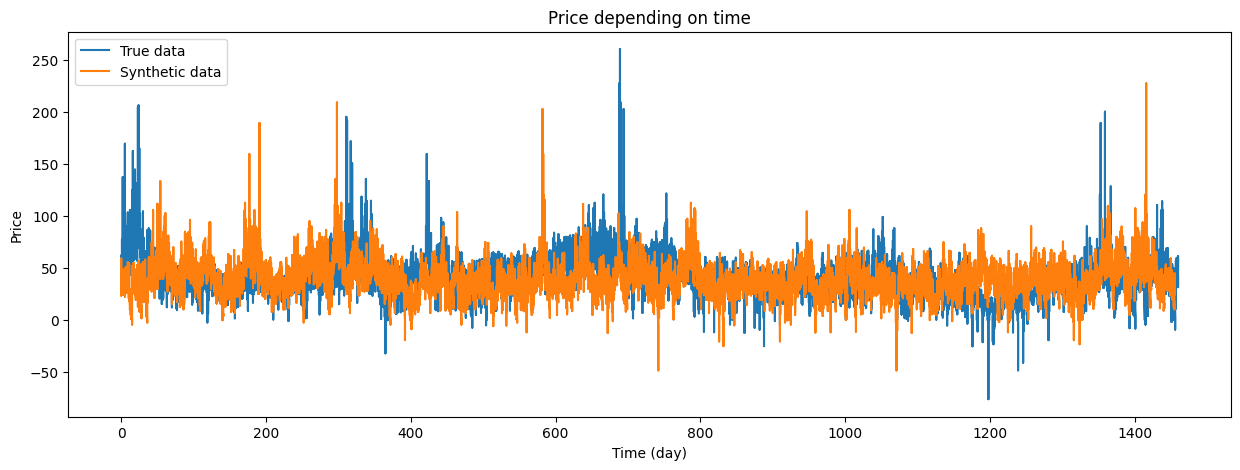

In [175]:
plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["dayofseries"], df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_00257_preprocessed["dayofseries"], df_price_generated_00257_preprocessed["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()

plt.show()

## Feature Engineering

One example x is `[dayofweek, hourofday, dayofseries]` or another set of attributes and y is `price`

In [176]:
def get_x_y_point_by_point(df, x_keys: List[str], y_key: str):
    X = df[x_keys]
    y = df[y_key]
    return X, y

One example x is a sequence of values of one attribute (e.g. x is `dayofseries_1, dayofseries_2, ..., dayofseries_5`) using a window and y is `price`

In [177]:
def get_x_y_window(df, y_key: str, window_size: int, window_step: int, horizon: int):
    X , y  = [], []
    
    for i in range(0, len(df[y_key]) - window_size - horizon, window_step):
        X.append(df[y_key][i:i+window_size])
        y.append(df[y_key][i+window_size:i+window_size+horizon])
        
    return X, y

## Train & Test Splits

In [178]:
class DatasetWithWindow(torch.utils.data.Dataset):
    def __init__(self, data, x_features, y_feature, window_size, window_step, horizon):
        self.X = torch.tensor(data[x_features].values, dtype=torch.float32)
        self.y = torch.tensor(data[y_feature].values, dtype=torch.float32).unsqueeze(-1)
        
        self.window_size = window_size
        self.window_step = window_step
        self.horizon = horizon
        self.length = (len(self.X) - window_size) // window_step + 1
        # print(f"length: {self.length}, window_size: {window_size}, window_step: {window_step}, len(X): {len(self.X)}")

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        start = index * self.window_step
        end = start + self.window_size
        
        if end > len(self.X) or end > len(self.y):
            raise IndexError("Index out of range")
        window = self.X[start:end]
        target = self.y[start:end]
        return window, target

def get_datasets(df, window_size, window_step, horizon, x_keys, y_key):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    
    train_dataset = DatasetWithWindow(train_df, x_keys, y_key, window_size, window_step, horizon)
    test_dataset = DatasetWithWindow(test_df, x_keys, y_key, window_size, window_step, horizon)
    
    return train_dataset, test_dataset

## Training functions

In [187]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super().__init__()
        # batch_first is True because we have the shape (batch_size, ...) https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self._lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self._linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x, _ = self._lstm(x)
        x = self._linear(x)
        return x

def train_model(dataloader, lr=0.001, n_epochs=50, hidden_size=32, n_layers=1):
    X_batch, y_batch = next(iter(dataloader))
    input_dim = X_batch.shape[-1]
    output_dim = 1
    
    model = LSTMModel(input_dim, output_dim, hidden_size, n_layers)
    loss_function = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    model.train()
    
    with tqdm(range(n_epochs)) as pbar:
        for _ in pbar:
            avg_loss = 0
            count = 0
            for X_batch, y_batch in dataloader:
                y_pred = model(X_batch)
                loss = loss_function(y_pred, y_batch)
                avg_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                count += 1
            avg_loss /= count
            pbar.set_description(f"Train loss: {avg_loss}")
        
    return model

def test_model(predictions, ground_truth):
    mse_function = nn.MSELoss()
        
    return {
        "mse": mse_function(predictions, ground_truth).item(),
        "mae": torch.mean(torch.abs(predictions - ground_truth)).item(),
        "rmse": torch.sqrt(torch.mean((predictions - ground_truth)**2)).item()
    }

def predict(model, dataloader):
    predictions = []
    ground_truth = []
    model.eval()
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    
    return predictions, ground_truth
        

def plot_predictions_vs_real(x_test, y_test, predictions):
    x_test_total_hours = x_test["dayofseries"]*24 + x_test["hourofday"]
    plt.scatter(x_test_total_hours, y_test, color = 'r', label="True")
    plt.scatter(x_test_total_hours, predictions, color = 'b', label="Prediction")
    plt.title('Real vs predicted prices depending on time')
    plt.xlabel('Time (h)')
    plt.ylabel('Price')
    plt.legend()

    plt.show()

## Without data augmentation

In [180]:
train_dataset, test_dataset = get_datasets(df_price_preprocessed, 24, 12, 24, ["dayofweek", "hourofday", "dayofseries"], "price")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 3, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 3, shuffle = False)

#### Train and eval

In [190]:
model = train_model(train_dataloader, lr=0.05, n_epochs=20)

Train loss: 233.02048699926866: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]

Results: {'mse': 92.72525024414062, 'mae': 6.838578701019287, 'rmse': 9.629395484924316}


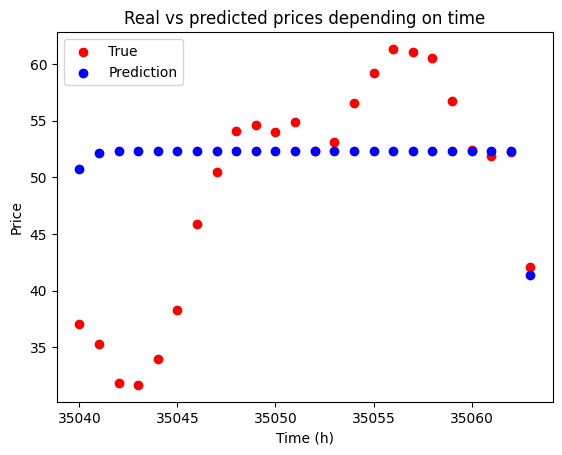

In [191]:
predictions, ground_truth = predict(model, test_dataloader)
results = test_model(predictions, ground_truth)
print("Results:", results)
plot_predictions_vs_real(df_price_preprocessed[-24:], ground_truth, predictions)

### With provided data augmentation (synthetic data)

In [213]:
def load_synthetic_datasets(path, max_num_fetched=None):
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_dataset, _ = get_datasets(df_preprocessed, 24, 12, 24, ["dayofweek", "hourofday", "dayofseries"], "price")
           
            train_all.append(train_dataset)
    
    return train_all

In [214]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, 5)

  3%|▎         | 5/154 [00:09<04:48,  1.94s/it]


In [215]:
train_concat = ConcatDataset(train_all)
train_dataloader = torch.utils.data.DataLoader(train_concat, batch_size = 3, shuffle = False)

In [216]:
model = train_model(train_dataloader, lr=0.05, n_epochs=20)

Train loss: 322.4425348221678: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it] 


100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]

Results: {'mse': 160.64195251464844, 'mae': 11.558258056640625, 'rmse': 12.674460411071777}


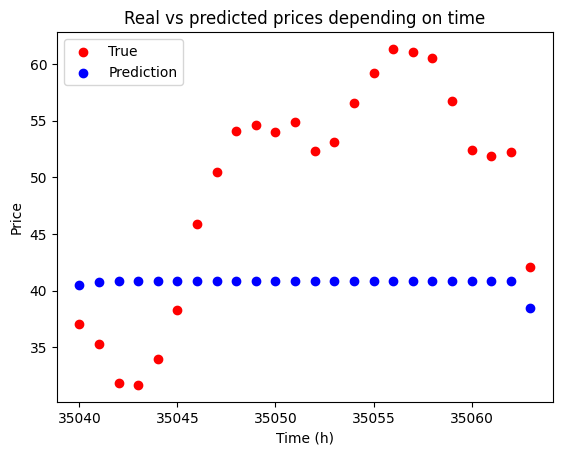

In [217]:
predictions, ground_truth = predict(model, test_dataloader)
results = test_model(predictions, ground_truth)
print("Results:", results)
plot_predictions_vs_real(df_price_preprocessed[-24:], ground_truth, predictions)